In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Project/NeuralOptimalTransport-main/')

# /content/drive/MyDrive/Project/NeuralOptimalTransport-main

In [3]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# ! pip install wandb

In [5]:
import src

In [6]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats

# from src.tools_modified import load_dataset_modified 
from src.tools_modified_v2 import load_dataset_modified 


from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

## Main Config

In [7]:
DEVICE_IDS = [0]

DATASET1, DATASET1_PATH = 'MNIST-colored_2', '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/MNIST-colored_2_32_test_new.torch'
DATASET2, DATASET2_PATH = 'MNIST-colored_3', '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/MNIST-colored_3_32_test_new.torch'


IMG_SIZE = 32



## Preparation

In [8]:
torch.cuda.is_available()

True

## Loading data stats for testing

In [9]:
filename = '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/{}_{}_test_new.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

## Prepare Samplers (X, Y)

In [10]:
X_sampler, X_test_sampler = load_dataset_modified(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_sampler, Y_test_sampler = load_dataset_modified(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


72

### Plots Test Inverse mapping

#### Loading Models

In [11]:
# /content/drive/MyDrive/Project/NeuralOptimalTransport-main/models_from_Luel/f_0_52499.pth

# /content/drive/MyDrive/Project/NeuralOptimalTransport-main/models_from_Luel/T_0_52499.pth

from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/content/drive/MyDrive/Project/NeuralOptimalTransport-main/models_from_Luel")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
best_f_trained = "f_0_52499.pth"
best_T_trained = "T_0_52499.pth"

best_f_path = MODEL_PATH / best_f_trained
best_T_path = MODEL_PATH / best_T_trained


In [12]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9715827
f params: 13494209


In [13]:
f.load_state_dict(torch.load(best_f_path))

T.load_state_dict(torch.load(best_T_path))

<All keys matched successfully>

In [14]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

################################################

Y_fixed.requires_grad = True
f_Y =  f(Y_fixed) 

f_Y.backward(torch.ones(Y_fixed.shape[0],1).cuda())

Y_rev = Y_fixed - Y_fixed.grad * (3*32*32/2)

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt



import warnings

	
warnings.filterwarnings('always')
warnings.filterwarnings('ignore', message='.*MatplotlibDeprecationWarning.*')
warnings.warn('some text MatplotlibDeprecationWarning some other text\n another line')

In [16]:
# plt.imshow(Y_rev[1].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)
# plt.imshow(Y_fixed[1].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)

### Inverse mapping using our best trained regularized model

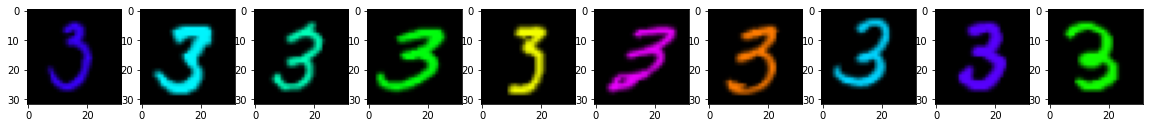

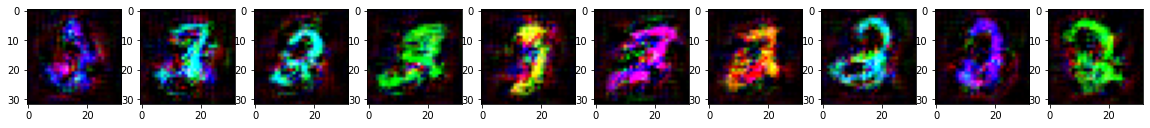

In [17]:

plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(Y_fixed[i].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)     
# plt.title("Inverse mapping: Digits 3 to 2")      
plt.show()

plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(Y_rev[i].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)
plt.show()



### Compairing reg-NOT and NOT on inverse mapping task

Note: The models used are saved at the 7499 step

#### reg-NOT

T params: 9715827
f params: 13494209


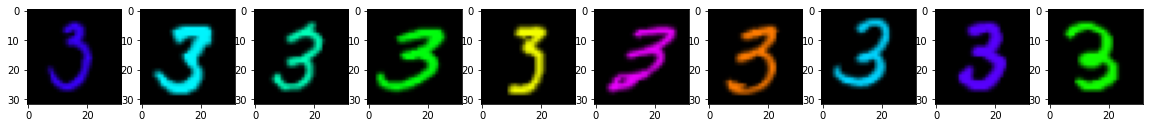

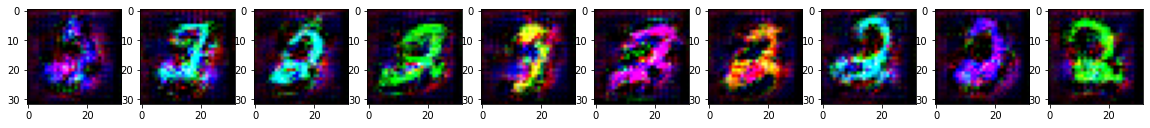

In [18]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/content/drive/MyDrive/Project/NeuralOptimalTransport-main/models_from_Luel")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
best_f_trained = "f_0_7499.pth"
best_T_trained = "T_0_7499.pth"

best_f_path = MODEL_PATH / best_f_trained
best_T_path = MODEL_PATH / best_T_trained



f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))



f.load_state_dict(torch.load(best_f_path))

T.load_state_dict(torch.load(best_T_path))



# torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
# X_fixed = X_sampler.sample(10)
# Y_fixed = Y_sampler.sample(10)
# X_test_fixed = X_test_sampler.sample(10)
# Y_test_fixed = Y_test_sampler.sample(10)

################################################

Y_fixed.requires_grad = True
f_Y =  f(Y_fixed) 

f_Y.backward(torch.ones(Y_fixed.shape[0],1).cuda())

Y_rev = Y_fixed - Y_fixed.grad * (3*32*32/2)


plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(Y_fixed[i].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)     
# plt.title("Inverse mapping: Digits 3 to 2")      
plt.show()

plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(Y_rev[i].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)
plt.show()


### NOT-Strong

T params: 9715827
f params: 13494209


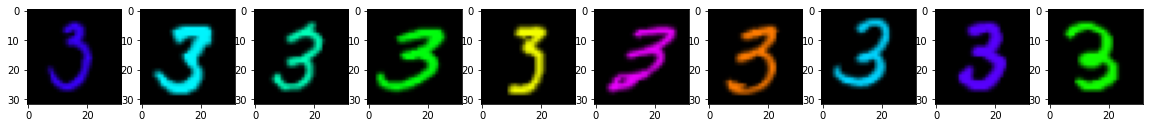

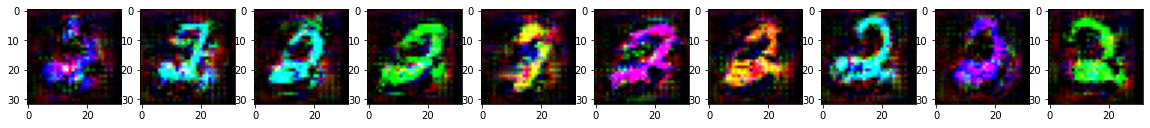

In [19]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/content/drive/MyDrive/Project/NeuralOptimalTransport-main/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
best_f_trained = "NOT_project2_Ak_f_0_7499.pth"
best_T_trained = "NOT_project1_Ak_T_0_7499.pth"

best_f_path = MODEL_PATH / best_f_trained
best_T_path = MODEL_PATH / best_T_trained


# /content/drive/MyDrive/Project/NeuralOptimalTransport-main/models/NOT_project2_Ak_f_0_7499.pth
# /content/drive/MyDrive/Project/NeuralOptimalTransport-main/models/NOT_project1_Ak_T_0_7499.pth


f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))



f.load_state_dict(torch.load(best_f_path))

T.load_state_dict(torch.load(best_T_path))



# torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
# X_fixed = X_sampler.sample(10)
# Y_fixed = Y_sampler.sample(10)
# X_test_fixed = X_test_sampler.sample(10)
# Y_test_fixed = Y_test_sampler.sample(10)

################################################

Y_fixed.requires_grad = True
f_Y =  f(Y_fixed) 

f_Y.backward(torch.ones(Y_fixed.shape[0],1).cuda())

Y_rev = Y_fixed - Y_fixed.grad * (3*32*32/2)


plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(Y_fixed[i].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)     
# plt.title("Inverse mapping: Digits 3 to 2")      
plt.show()

plt.figure(figsize=(20,10))
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(Y_rev[i].permute(1,2,0).cpu().detach().numpy()*0.5 +0.5)
plt.show()